Resumen de cambios en esta version. No necesariamente todos son definitivos, estuve borrando muchas cosas para que me sea mas facil de ir leyendo el archivo y quiza no queremos perder todo eso que borre.


1. Analisis de outlayers
2. La exploración de las correlaciones entre las localidades, tipos de propiedad y las superficies. Esto termina quedando en lo mismo (imputamos la superficie cubierta en base a la total y viceversa) pero agregando un poquito de desarrollo en el medio para que no parezca un tiro al aire
3. Algun detalle en la imputación, como el de corregir las habitaciones imputadas cuando tenemos 1 solo ambiente (al asignar ambiente - 1 como cantidad de habitaciones nos habia quedado 0)
4. Borré longitud y latitud porque no estoy viendo que lo vayamos a usar. Quizas los terminamos agregando de nuevo para buscar proximidad a [subte, tren, lo que sea] pero por el momento nada

In [94]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.stats import gaussian_kde
from sklearn.model_selection import train_test_split

In [95]:
path_df = "properati_argentina_2021.csv"

In [96]:
GREEN = "#196F3D"
BLUE = "#2874A6"

In [97]:
df_raw = pd.read_csv(path_df)

In [98]:
df_raw.shape

(460154, 20)

In [99]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 460154 entries, 0 to 460153
Data columns (total 20 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   id                        460154 non-null  object 
 1   start_date                460154 non-null  object 
 2   end_date                  460154 non-null  object 
 3   created_on                460154 non-null  object 
 4   latitud                   419740 non-null  float64
 5   longitud                  419740 non-null  float64
 6   place_l2                  460154 non-null  object 
 7   place_l3                  437665 non-null  object 
 8   place_l4                  139020 non-null  object 
 9   place_l5                  2430 non-null    object 
 10  place_l6                  0 non-null       float64
 11  operation                 460154 non-null  object 
 12  property_type             460154 non-null  object 
 13  property_rooms            368498 non-null  f

In [100]:
df_raw.head(3)

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,place_l5,place_l6,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency,property_title
0,XZq2dFGxBiboHY3Bo/tqlw==,2021-09-09,2022-01-27,2021-09-09,-38.957632,-68.105443,Neuquén,NaN,NaN,NaN,NaN,Venta,Casa,6.0,NaN,NaN,206.0,NaN,NaN,Casa - Capital
1,8afoK+yMH/rnnlYiktwgNA==,2021-09-09,2021-10-23,2021-09-09,-34.888878,-56.092368,Montevideo,NaN,NaN,NaN,NaN,Venta,Casa,4.0,3.0,193.0,193.0,390000.0,USD,Casa - Malvín
2,iVaG5rBB47dd1Ya4BMXREA==,2021-09-09,2022-03-09,2021-09-09,-32.488717,-58.257499,Entre Ríos,NaN,NaN,NaN,NaN,Venta,Casa,NaN,NaN,110.0,45.0,47000.0,USD,Casa - Uruguay


In [101]:
tipos_propiedades = ["Departamento", "Casa", "PH"]

In [102]:
## Filtramos el df con lo solicitado
df_raw = df_raw[(df_raw["property_currency"] == "USD") & (df_raw["operation"] == "Venta") & (df_raw["property_type"].isin(tipos_propiedades)) &
        (df_raw["place_l2"] == "Capital Federal")]

## Dividimos en un df para entrenamiento (llamado df) y otro para test (df_test)
seed = 123

_df, df_test = train_test_split(df_raw, test_size=0.2, random_state=seed)

df = _df # creo esta copia para luego poder comparar las distros antes y despues de imputar datos.

print(df_raw.shape)
print(_df.shape)
print(df_test.shape)

(94249, 20)
(75399, 20)
(18850, 20)


Hay 198 propiedades con errores en la superficie

Decidimos tomar como que el error estuvo en ingresar los datos al revés.

In [103]:
filas_erroneas = df["property_surface_total"] < df["property_surface_covered"]

df.loc[filas_erroneas, ["property_surface_total", "property_surface_covered"]] = df.loc[filas_erroneas, ["property_surface_covered", "property_surface_total"]].values

Como las columnas place_l4, place_l5 y place_l6 tiene un 96,13%, 100% y 100% de nulos, respectivamente, las elimino.

In [104]:
df = df.drop("place_l4", axis=1)
df = df.drop("place_l5", axis=1)
df = df.drop("place_l6", axis=1)

Como las filas que no tienen ninguno de los datos de habitaciones/ambientes son solo 432 para un df de 94342, elimino dichas filas.

In [105]:
df = df[~(df["property_rooms"].isnull() & df["property_bedrooms"].isnull())]

Busco si hay propiedades que tengan valores nulos para la cantidad de ambientes y no nulos para la cantidad de habitaciones.

In [106]:
df[df["property_rooms"].isnull() & ~df["property_bedrooms"].isnull()].shape[0]

493

Completo aquellas filas que no tengan la cantidad de cuartos totales, pero si la cantidad de habitaciones, con cantHabitaciones + 1, ya que necesariamente tienen un ambiente más.

In [107]:
df["property_rooms"].fillna(df["property_bedrooms"] + 1, inplace=True)

Completamos ahora con la logica inversa aquellas viviendas que tengan el valor nulo en habitaciones pero no nulo en ambientes.

In [108]:
df[~(df["property_rooms"].isnull()) & (df["property_bedrooms"].isnull())].shape[0]

8380

In [109]:
df["property_bedrooms"].fillna(df["property_rooms"] - 1, inplace=True)

#Relleno con 1 los que quedaron en 0 que son los monoambientes imputados por la linea anterior
df.loc[df['property_bedrooms'] == 0, 'property_bedrooms'] = 1

#Corrijo los datos donde la cantidad de habitaciones es mayor a la cantidad de ambientes
df.loc[df['property_bedrooms'] > df['property_rooms'], 'property_bedrooms'] = df['property_rooms']


Busco ahora la forma que tienen los datos nulos respecto a las superficies (total y descubierta)

In [110]:
barrios = df["place_l3"].value_counts().index.tolist()
barrios = [b.upper() for b in barrios]

In [111]:
barrios

['PALERMO',
 'BELGRANO',
 'CABALLITO',
 'RECOLETA',
 'VILLA URQUIZA',
 'ALMAGRO',
 'NUÑEZ',
 'VILLA CRESPO',
 'FLORES',
 'BARRIO NORTE',
 'BALVANERA',
 'COLEGIALES',
 'VILLA DEVOTO',
 'VILLA DEL PARQUE',
 'SAAVEDRA',
 'PUERTO MADERO',
 'SAN TELMO',
 'SAN NICOLÁS',
 'SAN CRISTOBAL',
 'BARRACAS',
 'RETIRO',
 'BOEDO',
 'FLORESTA',
 'MONSERRAT',
 'PARQUE CHACABUCO',
 'VILLA PUEYRREDÓN',
 'COGHLAN',
 'VILLA LURO',
 'MATADEROS',
 'CHACARITA',
 'LINIERS',
 'VILLA ORTUZAR',
 'VILLA LUGANO',
 'PARQUE PATRICIOS',
 'PATERNAL',
 'CONGRESO',
 'MONTE CASTRO',
 'VILLA GENERAL MITRE',
 'CONSTITUCIÓN',
 'VILLA SANTA RITA',
 'ONCE',
 'PARQUE CHAS',
 'PARQUE AVELLANEDA',
 'BOCA',
 'VERSALLES',
 'VELEZ SARSFIELD',
 'AGRONOMÍA',
 'ABASTO',
 'POMPEYA',
 'VILLA REAL',
 'TRIBUNALES',
 'PARQUE CENTENARIO',
 'CENTRO / MICROCENTRO',
 'VILLA SOLDATI',
 'VILLA RIACHUELO',
 'LAS CAÑITAS',
 'CATALINAS']

Podria buscar en property_title los barrios publicados y ubicarlos en los place_l3 faltantes, pero tranquilamente podrian haber, por intereses del vendedor/la inmboliaria viviendas que correspondan a un barrio pero estan publicados en otro, por ahora ignoraremos eso.

In [112]:
df["property_title"] = df["property_title"].str.upper()

In [113]:
for b in barrios:
    df.loc[(df["place_l3"].isnull()) & (df["property_title"].str.contains(b)), "place_l3"] = b

In [114]:
#Elimino las columnas id, start_date, end_date, created_on, latitud, longitud, property_currency y operation

df = df.drop("id", axis=1)
df = df.drop("start_date", axis=1)
df = df.drop("end_date", axis=1)
df = df.drop("created_on", axis=1)
# df = df.drop("latitud", axis=1) # No la dropeo todavía, aunque no vamos a utilizar el valor al menos por el momento
# df = df.drop("longitud", axis=1) # No la dropeo todavía, aunque no vamos a utilizar el valor al menos por el momento
df = df.drop("property_currency", axis=1)
df = df.drop("operation", axis=1)


In [115]:
df = df.dropna(subset=['place_l3'])

In [116]:
null_counts_surface_covered = df[df['property_surface_covered'].isnull()].groupby('property_type').size()

print(null_counts_surface_covered)


property_type
Casa              84
Departamento    2344
PH               184
dtype: int64


In [117]:
df.isnull().sum()

latitud                     2840
longitud                    2840
place_l2                       0
place_l3                       0
property_type                  0
property_rooms                 0
property_bedrooms              0
property_surface_total      3720
property_surface_covered    2612
property_price                 0
property_title                 0
dtype: int64

In [118]:
# Obtengo correlación entre la superficie total y cubierta para cada tipo de propiedad
correlation_by_type = df.groupby('property_type').apply(lambda x: x['property_surface_total'].corr(x['property_surface_covered']))

print(correlation_by_type)


property_type
Casa            0.925068
Departamento    0.558473
PH              0.973656
dtype: float64


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)


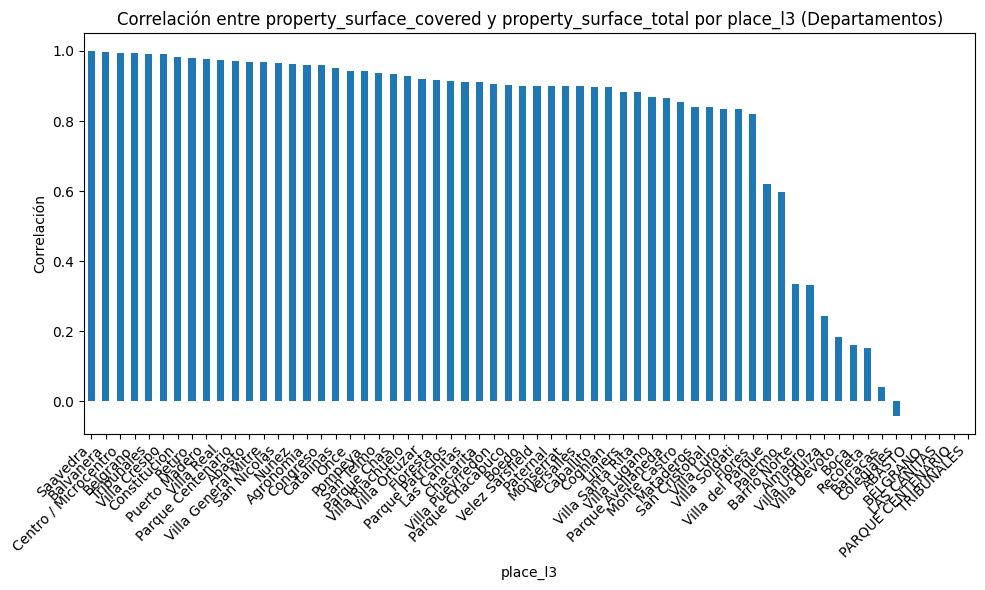

In [119]:
# Conociendo estos valores, Para casas y PH podemos imputar los nulls de una columna con el dato de la otra para casas y PH con un bajo margen de error.


# Correlación entre property_surface_covered y property_surface_total para propiedades del tipo departamento por cada place_l3

# Filtrar el DataFrame para incluir solo propiedades del tipo 'Departamento'
df_departamentos = df[df['property_type'] == 'Departamento']

# Calcular la correlación por cada place_l3
correlation_by_place_l3 = df_departamentos.groupby('place_l3').apply(lambda x: x['property_surface_covered'].corr(x['property_surface_total']))

correlation_by_place_l3_sorted = correlation_by_place_l3.sort_values(ascending=False)

# Graficar la correlación en un gráfico de barras
plt.figure(figsize=(10, 6))
correlation_by_place_l3_sorted.plot(kind='bar')
plt.title('Correlación entre property_surface_covered y property_surface_total por place_l3 (Departamentos)')
plt.xlabel('place_l3')
plt.ylabel('Correlación')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

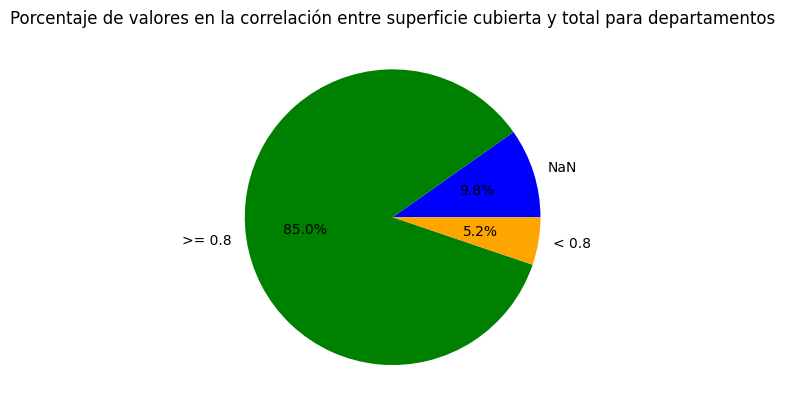

In [120]:
total_values = len(correlation_by_place_l3)

# Calcular los porcentajes
percent_nan = (correlation_by_place_l3.isnull().sum() / total_values) * 100
percent_08 = (np.sum(correlation_by_place_l3[correlation_by_place_l3 >= 0.8]) / total_values) * 100
percent_lt_09 = (np.sum(correlation_by_place_l3[(correlation_by_place_l3 >= 0) & (correlation_by_place_l3 < 0.8)]) / total_values) * 100

# Etiquetas y valores para el gráfico
labels = ['NaN', '>= 0.8', '< 0.8']
percentages = [percent_nan, percent_08, percent_lt_09]

# Graficar
plt.pie(percentages, labels=labels, autopct='%1.1f%%', colors=['blue', 'green', 'orange'])
plt.title('Porcentaje de valores en la correlación entre superficie cubierta y total para departamentos')
plt.show()

In [121]:
# Reemplazar los valores nulos en 'property_surface_total' con los valores de 'property_surface_covered'
df.loc[(df['property_surface_total'].isnull()), 'property_surface_total'] = df['property_surface_covered']

# Reemplazar los valores nulos en 'property_surface_covered' con los valores de 'property_surface_total'
df.loc[(df['property_surface_covered'].isnull()), 'property_surface_covered'] = df['property_surface_total']

In [122]:
# Sumo features: precio por m2 cubierto y por m2 total

df["total_m2_price"] = df["property_price"] / df["property_surface_total"]
df["covered_m2_price"] = df["property_price"] / df["property_surface_covered"]

In [123]:
# Aplico one hot encoding

df = pd.get_dummies(df, columns=['property_type'])



In [124]:
df.isnull().sum()

latitud                       2840
longitud                      2840
place_l2                         0
place_l3                         0
property_rooms                   0
property_bedrooms                0
property_surface_total           0
property_surface_covered         0
property_price                   0
property_title                   0
total_m2_price                   0
covered_m2_price                 0
property_type_Casa               0
property_type_Departamento       0
property_type_PH                 0
dtype: int64

## Valores atípicos

## Superficie total y cubierta

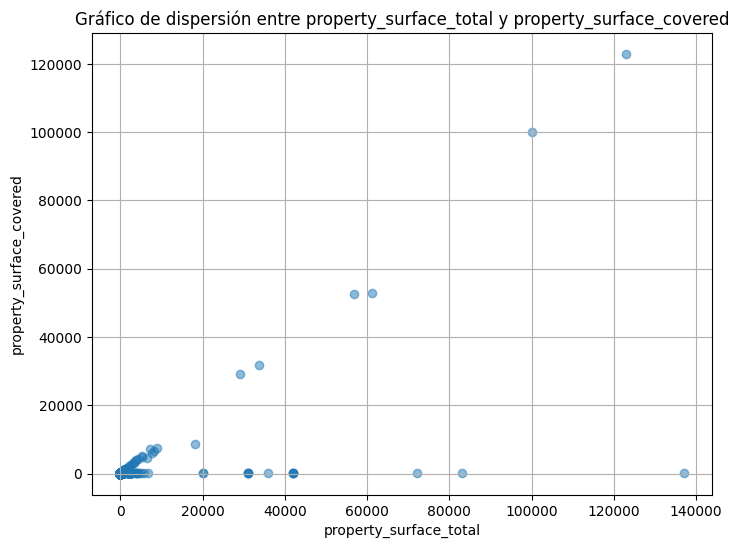

In [125]:
# Dispesión de superficie total y cubierta
plt.figure(figsize=(8, 6))
plt.scatter(df['property_surface_total'], df['property_surface_covered'], alpha=0.5)
plt.title('Gráfico de dispersión entre property_surface_total y property_surface_covered')
plt.xlabel('property_surface_total')
plt.ylabel('property_surface_covered')
plt.grid(True)
plt.show()


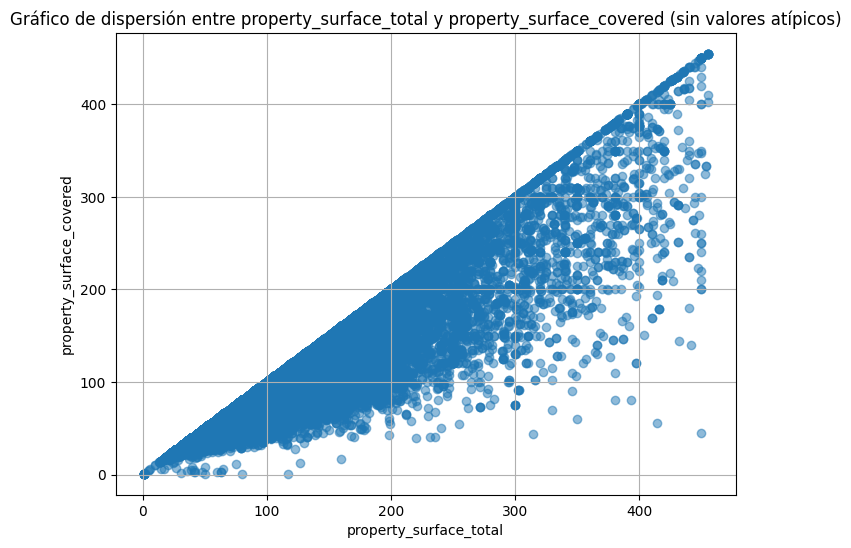

In [126]:
# Calcular la mediana de 'property_surface_total'
mediana = df['property_surface_total'].median()

# Definir el límite superior
limite_superior = mediana * 7

# Filtrar el DataFrame para eliminar valores atípicos
df = df[df['property_surface_total'] <= limite_superior]

# Crear el gráfico de dispersión con el DataFrame filtrado
plt.figure(figsize=(8, 6))
plt.scatter(df['property_surface_total'], df['property_surface_covered'], alpha=0.5)
plt.title('Gráfico de dispersión entre property_surface_total y property_surface_covered (sin valores atípicos)')
plt.xlabel('property_surface_total')
plt.ylabel('property_surface_covered')
plt.grid(True)
plt.show()

## Habitaciones y ambientes

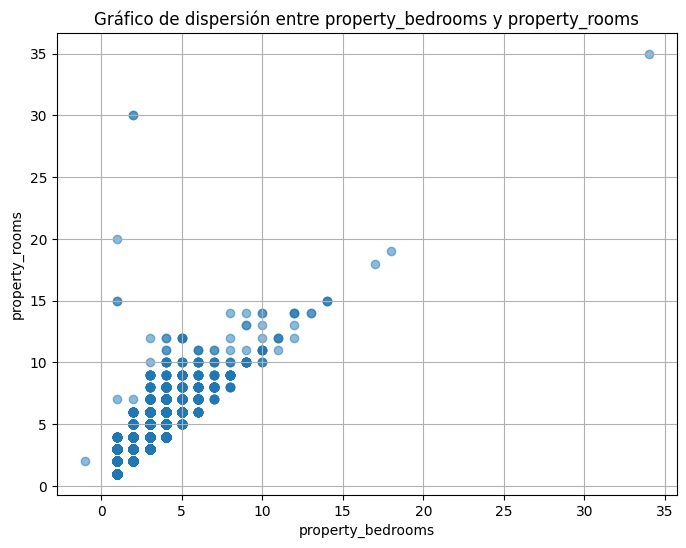

In [127]:
# Dispesión de superficie total y cubierta
plt.figure(figsize=(8, 6))
plt.scatter(df['property_bedrooms'], df['property_rooms'], alpha=0.5)
plt.title('Gráfico de dispersión entre property_bedrooms y property_rooms')
plt.xlabel('property_bedrooms')
plt.ylabel('property_rooms')
plt.grid(True)
plt.show()


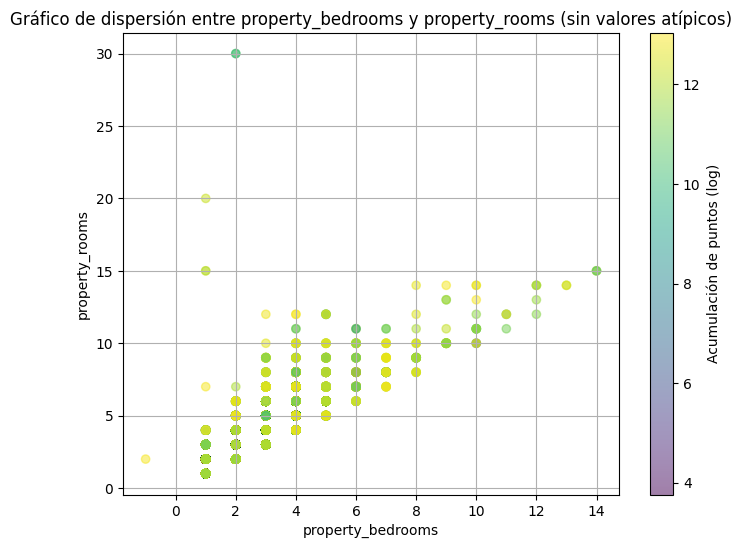

In [128]:
# Calcular la mediana de 'property_surface_total'
mediana = df['property_bedrooms'].median()

# Definir el límite superior
limite_superior = mediana * 7

# Filtrar el DataFrame para eliminar valores atípicos
df = df[df['property_bedrooms'] <= limite_superior]

# Crear el gráfico de dispersión con la gama de colores para la acumulación de puntos
plt.figure(figsize=(8, 6))
plt.scatter(df['property_bedrooms'], df['property_rooms'], c=np.log(df.index + 1), cmap='viridis', alpha=0.5)
plt.title('Gráfico de dispersión entre property_bedrooms y property_rooms (sin valores atípicos)')
plt.xlabel('property_bedrooms')
plt.ylabel('property_rooms')
plt.colorbar(label='Acumulación de puntos (log)')
plt.grid(True)
plt.show()


## Precios

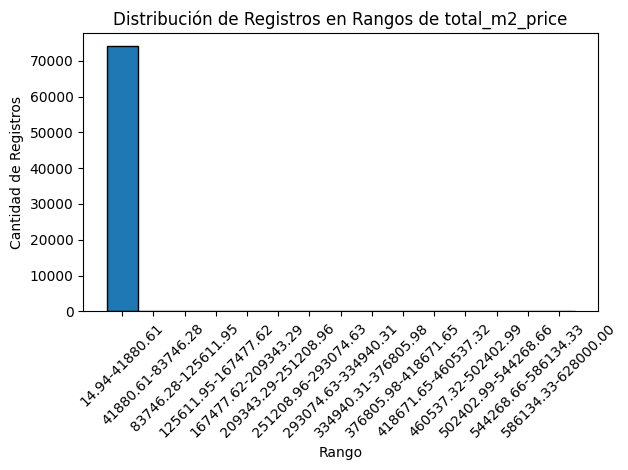

In [129]:
# Generar 15 rangos iguales
num_bins = 15
bin_width = (df['total_m2_price'].max() - df['total_m2_price'].min()) / num_bins
bins = [df['total_m2_price'].min() + i * bin_width for i in range(num_bins + 1)]

# Contar la cantidad de registros en cada rango
hist, bins = np.histogram(df['total_m2_price'], bins=bins)

# Crear el gráfico
plt.bar(range(len(hist)), hist, width=1, edgecolor='black')

# Añadir etiquetas y título
plt.xlabel('Rango')
plt.ylabel('Cantidad de Registros')
plt.title('Distribución de Registros en Rangos de total_m2_price')

# Añadir etiquetas de los rangos en el eje x
plt.xticks(range(len(hist)), [f'{bins[i]:.2f}-{bins[i+1]:.2f}' for i in range(len(hist))], rotation=45)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

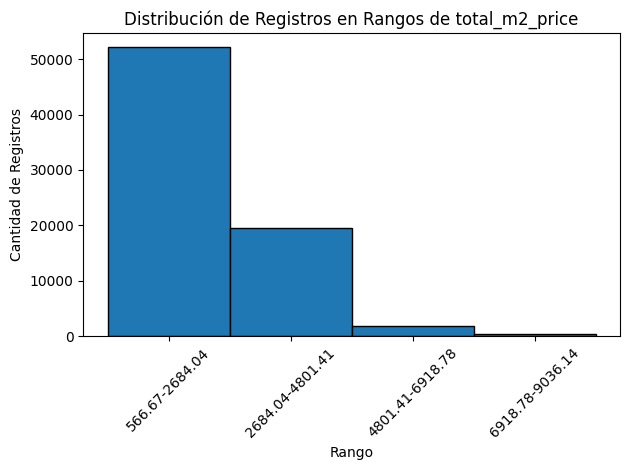

In [138]:
# Vemos que hay numeros irrisorios. Tomo la media y elimino en un rango de 5 veces menor y 5 veces mayor
mediana_total_m2_price = df['total_m2_price'].median()

limite_inferior = mediana_total_m2_price / 5
limite_superior = mediana_total_m2_price * 5

df = nuevo_df = df[(df['total_m2_price'] >= limite_inferior) & (df['total_m2_price'] <= limite_superior)]

# Generar 4 rangos iguales
num_bins = 4
bin_width = (df['total_m2_price'].max() - df['total_m2_price'].min()) / num_bins
bins = [df['total_m2_price'].min() + i * bin_width for i in range(num_bins + 1)]

# Contar la cantidad de registros en cada rango
hist, bins = np.histogram(df['total_m2_price'], bins=bins)

# Crear el gráfico
plt.bar(range(len(hist)), hist, width=1, edgecolor='black')

# Añadir etiquetas y título
plt.xlabel('Rango')
plt.ylabel('Cantidad de Registros')
plt.title('Distribución de Registros en Rangos de total_m2_price')

# Añadir etiquetas de los rangos en el eje x
plt.xticks(range(len(hist)), [f'{bins[i]:.2f}-{bins[i+1]:.2f}' for i in range(len(hist))], rotation=45)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

In [139]:
# Despues de revisar todos estos valores atípicos vemos que borramos aprox 5k filas de las 75399 con las que empezamos. No me parece mal
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 73776 entries, 129124 to 74957
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   latitud                     70973 non-null  float64
 1   longitud                    70973 non-null  float64
 2   place_l2                    73776 non-null  object 
 3   place_l3                    73776 non-null  object 
 4   property_rooms              73776 non-null  float64
 5   property_bedrooms           73776 non-null  float64
 6   property_surface_total      73776 non-null  float64
 7   property_surface_covered    73776 non-null  float64
 8   property_price              73776 non-null  float64
 9   property_title              73776 non-null  object 
 10  total_m2_price              73776 non-null  float64
 11  covered_m2_price            73776 non-null  float64
 12  property_type_Casa          73776 non-null  bool   
 13  property_type_Departamento  737